In [100]:
import numpy as np 
import pandas as pd 
import emoji
import os
import keras
import preprocessor as p
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional, Embedding
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras_preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import transformers
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
data = pd.read_csv('text_emotion.csv')

In [5]:
data=data[['sentiment','content']]
data

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [6]:
misspell_data = pd.read_csv("aspell.txt",sep=":",names=["correction","misspell"])
misspell_dict=dict()
for misspell in misspell_data['misspell']:
    key=misspell.split()[0]
    misspell_dict[key] = misspell_data.loc[misspell_data['misspell']==misspell,'correction'].values[0]

In [7]:
def misspelled_correction(val):
    for x in val.split(): 
        if x in misspell_dict.keys(): 
            val = val.replace(x, misspell_dict[x]) 
    return val

data["clean_content"] = data['content'].apply(lambda x : misspelled_correction(x))
data = data.drop('content', axis=1)

In [8]:
contractions = pd.read_csv("contractions.csv")
cont_dict = dict(zip(contractions.Contraction, contractions.Meaning))

In [9]:
def contraction(val): 
    for x in val.split(): 
        if x in cont_dict.keys(): 
            val = val.replace(x, cont_dict[x]) 
    return val

In [10]:
data['clean_content'] = data['clean_content'].apply(lambda x : contraction(x))

In [11]:
#URL, and @ remover from preprocessor library
p.set_options(p.OPT.MENTION, p.OPT.URL)
p.clean("hello guys https://github.com/s/preprocessor")

'hello guys'

In [12]:
data['clean_content']=data['clean_content'].apply(lambda x : p.clean(x))

In [13]:
def punctuation(val): 
    punctuations = '''()-[]{};:'"\,<>./@#$%^&_~'''
    for x in val.lower(): 
        if x in punctuations: 
            val = val.replace(x, "") 
    return val

In [14]:
punctuation("me ''()-[]{};:'\,<>./@#$%^&_~' ? !  ")

'me  ? !  '

In [15]:
#punctuation and emojis
data['clean_content'] = data['clean_content'].apply(lambda x : ' '.join(punctuation(emoji.demojize(x)).split()))

In [16]:
#lowercase
data['clean_content']=data['clean_content'].str.lower()
#empty comments
data = data[data['clean_content'] != ""]
data

,sentiment,clean_content
0,empty,i know i was listenin to bad habit earlier and...
1,sadness,layin n bed with a headache ughhhhwaitin on yo...
2,sadness,funeral ceremonygloomy friday
3,enthusiasm,wants to hang out with friends soon!
4,neutral,we want to trade with someone who has houston ...
...,...,...
39994,happiness,succesfully following tayla!!
39996,love,happy mothers day all my love
39997,love,happy mothers day to all the mommies out there...
39998,happiness,wassup beautiful!!! follow me!! peep out my ne...


In [ ]:
# # Download the stopwords corpus if not already downloaded
# nltk.download('stopwords')
# nltk.download('punkt')
# # Define the set of stopwords
# stop_words = set(stopwords.words('english'))

# # Function to remove stopwords from a text string
# def remove_stopwords(text):
#     tokens = word_tokenize(text)  # Tokenize the text into words
#     filtered_tokens = [word for word in tokens if word.lower() not in stop_words]  # Filter out stopwords
#     filtered_text = ' '.join(filtered_tokens)  # Reconstruct the text without stopwords
#     return filtered_text

# # Apply the remove_stopwords function to the 'Text' column
# data['clean_content'] = data['clean_content'].apply(remove_stopwords)


In [17]:
data

,sentiment,clean_content
0,empty,i know i was listenin to bad habit earlier and...
1,sadness,layin n bed with a headache ughhhhwaitin on yo...
2,sadness,funeral ceremonygloomy friday
3,enthusiasm,wants to hang out with friends soon!
4,neutral,we want to trade with someone who has houston ...
...,...,...
39994,happiness,succesfully following tayla!!
39996,love,happy mothers day all my love
39997,love,happy mothers day to all the mommies out there...
39998,happiness,wassup beautiful!!! follow me!! peep out my ne...


In [18]:
data['sentiment'].value_counts()

neutral       8579
worry         8454
happiness     5208
sadness       5162
love          3841
surprise      2187
fun           1776
relief        1526
hate          1323
empty          815
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [19]:
labels= {"neutral":0, "worry":1,"happiness":2,"sadness":3,"love":4,"surprise":5,"fun":6,"relief":7,"hate":8,"empty":9,"enthusiasm":10,"boredom":11,"anger":12}

In [20]:
data["sentiment"] = data['sentiment'].replace(labels)


In [21]:
data

,sentiment,clean_content
0,9,i know i was listenin to bad habit earlier and...
1,3,layin n bed with a headache ughhhhwaitin on yo...
2,3,funeral ceremonygloomy friday
3,10,wants to hang out with friends soon!
4,0,we want to trade with someone who has houston ...
...,...,...
39994,2,succesfully following tayla!!
39996,4,happy mothers day all my love
39997,4,happy mothers day to all the mommies out there...
39998,2,wassup beautiful!!! follow me!! peep out my ne...


In [22]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data['sentiment'])
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
X_train, X_testval, y_train, y_testval = train_test_split(data['clean_content'],Y, random_state=42, test_size=0.2, shuffle=True)
X_test, X_val,y_test, y_val = train_test_split(X_testval,y_testval, random_state=42, test_size=0.5, shuffle=True)
print(len(X_train),len(X_test),len(X_val))

31935 3992 3992


In [24]:
maxl=0
for content in data['clean_content']:
    maxl=max(maxl,len(content.split()))
print(maxl)

34


In [25]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
token.fit_on_texts(list(X_train) + list(X_test)+list(X_val))
X_train_pad = pad_sequences(token.texts_to_sequences(X_train), maxlen=maxl+1)
X_val_pad = pad_sequences(token.texts_to_sequences(X_val), maxlen = maxl+1)
X_test_pad = pad_sequences(token.texts_to_sequences(X_test), maxlen=maxl+1)

In [26]:
word2idx = token.word_index
print(len(word2idx))

35574


## Bidirectional LSTM

In [ ]:
embeddings_index = {}
f = open(os.path.join('glove.6B.200d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs= np.asarray(values [1:], dtype='float32')
    embeddings_index [word] = np.array(coefs)
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_matrix = np.random.random((len(word2idx) + 1, 200))
for word, i in word2idx.items():
    if word in embeddings_index.keys():
        embedding_matrix[i] = embeddings_index[word]

In [ ]:
embed_dim = 200
lstm_out = 256

model_lstm = Sequential()
model_lstm.add(Embedding(len(word2idx) +1 , embed_dim,input_length = X_test_pad.shape[1],weights=[embedding_matrix],trainable=False))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2,return_sequences=True),input_shape=(35,200 )))
model_lstm.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model_lstm.add(keras.layers.core.Dense(13, activation='softmax'))
#adam rmsprop 
model_lstm.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
print(model_lstm.summary())

In [31]:
batch_size = 32
Epochs=10

In [ ]:

model_lstm.fit(X_train_pad, y_train, epochs = Epochs, batch_size=batch_size,validation_data=(X_val_pad, y_val))

In [ ]:
# model_lstm.save('bilstm.h5')
from keras.models import load_model

# Load the saved model
model_lstm = load_model('bilstm.h5')

In [52]:
def clean_text(val):
    val = misspelled_correction(val)
    val = contraction(val)
    val = p.clean(val)
    val = val.lower()
    val = ' '.join(punctuation(emoji.demojize(val)).split())
    return val

In [ ]:
def get_sentiment(model,text):
    text = clean_text(text)
    #tokenize
    twt = token.texts_to_sequences([text])
    twt = pad_sequences(twt, maxlen=maxl+1, dtype='int32')
    sentiment = model.predict(twt,batch_size=1,verbose = 2)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([labels.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    return result

In [ ]:
get_sentiment(model_lstm,"I am fed up of you")

In [32]:
maxl=36

## DistilBERT

In [27]:
AUTO = tf.data.experimental.AUTOTUNE
MODEL='distilbert-base-uncased'
dberttokenizer = AutoTokenizer.from_pretrained(MODEL)

In [37]:
def dbertencoder(texts,maxlen):
    dbencoder = dberttokenizer.batch_encode_plus( texts, 
    return_attention_mask=False, 
    return_token_type_ids=False,
    pad_to_max_length=True,
    max_length=maxlen
    )
    return np.array(dbencoder['input_ids'])
maxl=36
X_train_pdbert =pad_sequences(dberttokenizer(X_train.tolist(),padding=False)['input_ids'], maxlen=maxl,padding='post')
X_val_pdbert =pad_sequences(dberttokenizer(X_val.tolist(),padding=False)['input_ids'], maxlen=maxl,padding='post')
X_test_pdbert =pad_sequences(dberttokenizer(X_test.tolist(),padding=False)['input_ids'], maxlen=maxl,padding='post')

In [38]:
#Sample of the distilbert tokenizer
print((X_val_pdbert[49]))
print(X_train.tolist()[1])
print(dberttokenizer.decode(X_val_pdbert[49], skip_special_tokens=False))

[  101  2038  2012  2560  2382 11829 15424  2006  2014  3456   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
yaa! hi amy im showing my new friends our youtube
[CLS] has at least 30 bug bites on her legs [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [39]:
#Creating dataset for training testing and validation
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_pdbert, y_train)).repeat().shuffle(42).batch(batch_size).prefetch(AUTO)
)

val_dataset = (tf.data.Dataset.from_tensor_slices((X_val_pdbert, y_val)).batch(batch_size).cache().prefetch(AUTO))

test_dataset = (tf.data.Dataset.from_tensor_slices((X_test_pdbert, y_test)).batch(batch_size).cache().prefetch(AUTO)
)


In [46]:
distilbert = TFAutoModel.from_pretrained(MODEL)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [47]:
input_word_ids = Input(shape=(36,), dtype=tf.int32, name="input_word_ids")
sequence_output = distilbert(input_word_ids)[0]
cls = sequence_output[:, 0, :]
out = Dense(13, activation='softmax')(cls)
model_dbert = Model(inputs=input_word_ids, outputs=out)
model_dbert.compile(Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model_dbert.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 36)]             0         
                                                                 
 tf_distil_bert_model_2 (TFD  TFBaseModelOutput(last_h  66362880 
 istilBertModel)             idden_state=(None, 36, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_3   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_3 (Dense)             (None, 13)                9997      
                                                           

In [48]:
steps_per_epoch = X_train.shape[0]//batch_size
model_dbert.fit(train_dataset,steps_per_epoch=steps_per_epoch,validation_data=val_dataset,epochs=3)

Epoch 1/3
997/997 [==============================] - 178s 153ms/step - loss: 1.9147 - accuracy: 0.3433 - val_loss: 1.8481 - val_accuracy: 0.3627
Epoch 2/3
997/997 [==============================] - 138s 138ms/step - loss: 1.7414 - accuracy: 0.4008 - val_loss: 1.8329 - val_accuracy: 0.3737
Epoch 3/3
997/997 [==============================] - 137s 138ms/step - loss: 1.6490 - accuracy: 0.4369 - val_loss: 1.8585 - val_accuracy: 0.3720


In [49]:
model_dbert.save('dbert1.h5')
# model_dbert = load_model('dbert.h5')

In [50]:
def get_sentimentbert(model,text):
    text = clean_text(text)
    #tokenize
    toktext =pad_sequences(dberttokenizer([text],padding=False)['input_ids'], maxlen=maxl,padding='post')
    test1 = (tf.data.Dataset.from_tensor_slices(toktext).batch(1))
    #test1
    sentiment = model.predict(test1,verbose = 0)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([labels.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    return result

In [53]:
get_sentimentbert(model_dbert,"this is very beautiful")

,sentiment,percentage
0,neutral,8.0
1,worry,3.0
2,happiness,33.0
4,love,39.0
5,surprise,10.0
6,fun,3.0
7,relief,1.0
9,empty,1.0
10,enthusiasm,1.0


In [72]:
y_predicted = model_dbert.predict(X_test_pdbert)
print(y_predicted)

125/125 [==============================] - 6s 47ms/step
[[0.11550599 0.2039918  0.02336293 ... 0.01533402 0.01132008 0.00529537]
 [0.03802535 0.17957298 0.01213773 ... 0.00803527 0.02429814 0.00820231]
 [0.23252137 0.02626362 0.48525855 ... 0.06187559 0.00056426 0.00067831]
 ...
 [0.0420455  0.49817735 0.00393759 ... 0.00489943 0.00488462 0.00573407]
 [0.04464573 0.16153073 0.003519   ... 0.00421758 0.00689696 0.0068022 ]
 [0.23576096 0.04996109 0.34399918 ... 0.06892589 0.00121912 0.00101018]]


In [77]:
y_predicted = np.array(y_predicted)
max_indices = np.argmax(y_predicted, axis=1)
predictions = np.zeros_like(y_predicted)
predictions[np.arange(len(y_predicted)), max_indices] = 1
print(predictions[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


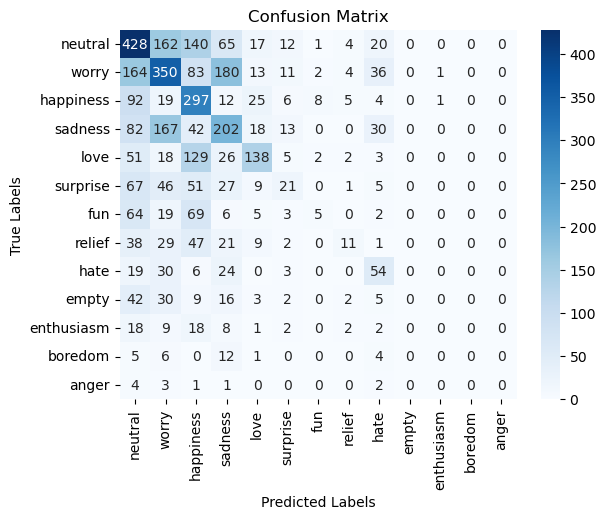

Precision score: 0.2504793546751102
Recall score: 0.22105949385942594
F1 score: 0.21129993129762067


In [103]:
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='macro')
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='macro')
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='macro')
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels,rotation=90)
ax.yaxis.set_ticklabels(labels,rotation=0)
plt.show()

print("Precision score:",precision )
print("Recall score:",recall )
print("F1 score:",f1 )

## BERT 

In [104]:
AUTO = tf.data.experimental.AUTOTUNE
MODEL2='bert-base-uncased'
berttokenizer = AutoTokenizer.from_pretrained(MODEL2)

In [105]:
def bertencoder(texts,maxlen):
    bencoder = berttokenizer.batch_encode_plus( texts, 
    return_attention_mask=False, 
    return_token_type_ids=False,
    pad_to_max_length=True,
    max_length=maxlen
    )
    return np.array(bencoder['input_ids'])
maxl=36
X_train_pbert =pad_sequences(berttokenizer(X_train.tolist(),padding=False)['input_ids'], maxlen=maxl,padding='post')
X_val_pbert =pad_sequences(berttokenizer(X_val.tolist(),padding=False)['input_ids'], maxlen=maxl,padding='post')
X_test_pbert =pad_sequences(berttokenizer(X_test.tolist(),padding=False)['input_ids'], maxlen=maxl,padding='post')

In [106]:
#Sample of the bert tokenizer
print((X_val_pbert[49]))
print(X_val.tolist()[49])
print(dberttokenizer.decode(X_val_pbert[49], skip_special_tokens=False))

[  101  2038  2012  2560  2382 11829 15424  2006  2014  3456   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
has at least 30 bug bites on her legs
[CLS] has at least 30 bug bites on her legs [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [107]:
#Creating dataset for training testing and validation
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_pbert, y_train)).repeat().shuffle(42).batch(batch_size).prefetch(AUTO)
)

val_dataset = (tf.data.Dataset.from_tensor_slices((X_val_pbert, y_val)).batch(batch_size).cache().prefetch(AUTO))

test_dataset = (tf.data.Dataset.from_tensor_slices((X_test_pbert, y_test)).batch(batch_size).cache().prefetch(AUTO)
)


In [108]:
bert = TFAutoModel.from_pretrained(MODEL2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [109]:
input_word_ids2 = Input(shape=(36,), dtype=tf.int32, name="input_word_ids2")
sequence_output2 = bert(input_word_ids2)[0]
cls = sequence_output2[:, 0, :]
out = Dense(13, activation='softmax')(cls)
model_bert = Model(inputs=input_word_ids2, outputs=out)
model_bert.compile(Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model_bert.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids2 (InputLayer  [(None, 36)]             0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             36, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                    

In [110]:
steps_per_epoch = X_train.shape[0]//batch_size
model_bert.fit(train_dataset,steps_per_epoch=steps_per_epoch,validation_data=val_dataset,epochs=3)

Epoch 1/3
997/997 [==============================] - 332s 281ms/step - loss: 1.8933 - accuracy: 0.3516 - val_loss: 1.8300 - val_accuracy: 0.3763
Epoch 2/3
997/997 [==============================] - 270s 271ms/step - loss: 1.7142 - accuracy: 0.4131 - val_loss: 1.8308 - val_accuracy: 0.3780
Epoch 3/3
997/997 [==============================] - 268s 269ms/step - loss: 1.6030 - accuracy: 0.4535 - val_loss: 1.8753 - val_accuracy: 0.3753


In [111]:
def get_sentimentBERT(model,text):
    text = clean_text(text)
    #tokenize
    toktext =pad_sequences(berttokenizer([text],padding=False)['input_ids'], maxlen=maxl,padding='post')
    test1 = (tf.data.Dataset.from_tensor_slices(toktext).batch(1))
    #test1
    sentiment = model.predict(test1,verbose = 0)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([labels.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    return result

In [112]:
y_predicted = model_bert.predict(X_test_pbert)
print(y_predicted)

125/125 [==============================] - 15s 90ms/step
[[0.12038603 0.14332741 0.01823083 ... 0.0105533  0.00665062 0.00613191]
 [0.05271702 0.18351352 0.01093574 ... 0.02693051 0.04050543 0.01182382]
 [0.32701156 0.0411603  0.3072843  ... 0.0617401  0.00044838 0.00045796]
 ...
 [0.01972925 0.37052387 0.00155317 ... 0.00674469 0.00485997 0.00913716]
 [0.03604071 0.17194861 0.00440905 ... 0.00259139 0.0049672  0.00715552]
 [0.33517358 0.04910146 0.26386434 ... 0.06096502 0.00083097 0.00043034]]


In [113]:
y_predicted = np.array(y_predicted)
max_indices = np.argmax(y_predicted, axis=1)
predictions = np.zeros_like(y_predicted)
predictions[np.arange(len(y_predicted)), max_indices] = 1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


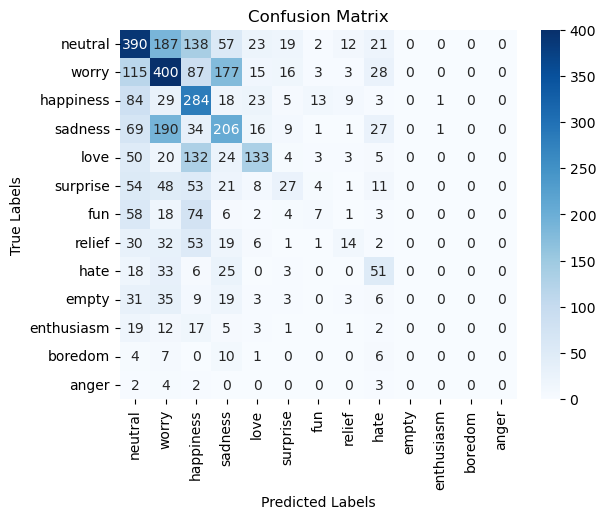

Precision score: 0.24245982975729732
Recall score: 0.22225463072032234
F1 score: 0.21509241361666123


In [114]:
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='macro')
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='macro')
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='macro')
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels,rotation=90)
ax.yaxis.set_ticklabels(labels,rotation=0)
plt.show()

print("Precision score:",precision )
print("Recall score:",recall )
print("F1 score:",f1 )

**The F1 score of DistilBERT is very close to that of BERT even while the DistilBERT has a reduced model size**